# Comparing Simple KNN to reduced KNN

It would be really interesting to see how PCA+KNN and ISOMAP+KNN would have performed, since it would significantly reduce memory requirements. Would it show similar performance as plain KNN or even improve accuracy?

For our discussion, we tried to answer my question by trying it with the data from the last training.

## Loading the data and required packages

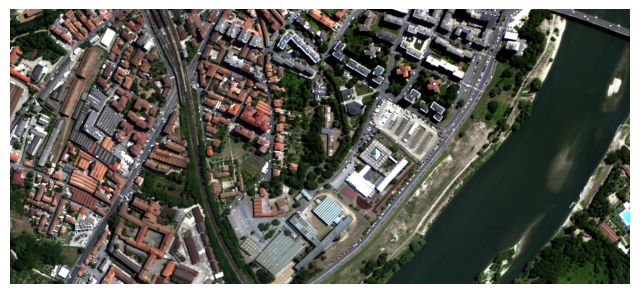

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

path = "C:/Users/louis/Desktop\Hyperspectral Remote Sensing/Sheet04/data"

image_path = f"{path}/rosis_pavia.tif"
image = rasterio.open(image_path)
image_data = image.read()

# this replaces the stretch='lin'
def linear_stretch(band, lower_percent=2, upper_percent=98):
    
    lower = np.percentile(band, lower_percent)
    upper = np.percentile(band, upper_percent)    # Clip and scale
    stretched_band = np.clip(band, lower, upper)
    stretched_band = (stretched_band - lower) / (upper - lower)
    return stretched_band
    
band15 = linear_stretch(image_data[15])   
band30 = linear_stretch(image_data[30])  
band43 = linear_stretch(image_data[43])
rgb = np.dstack((band43, band30, band15))

plt.figure(figsize=(8, 8))
plt.imshow(np.rot90(rgb, k=-1)) #rotating for smaller notebook
plt.axis('off')
plt.show()

### Q4.1 (1 pt): 
Which band combination is suitable for a false color NIR/R/G composite? Remember that ROSIS
is a half range sensor.

**Answer:** 80 for NIR seems to be suitable, producing an image that looks similar in color to the one from the last training (that was double the range and used 40).

In [3]:
import shapefile
from matplotlib.patches import Patch

# Transform shapefile coordinates to image coordinates
transform = image.transform
print(transform)

cal_sf = shapefile.Reader(f"{path}/rosis_calpoints.shp")

# coordinates to pixel indices
def coord_to_pixel(x, y, transform):
    col, row = ~transform * (x, y)
    return int(col), int(row)

def extract(sf):
    sf_shapes = sf.shapes()
    sf_records = sf.records()

    class_values = [record[1] for record in sf_records]

    # x and y coordinates
    shpx = [shape.points[0][0] for shape in sf_shapes]
    shpy = [shape.points[0][1] for shape in sf_shapes]

    pixel_coords = [coord_to_pixel(x, y, transform) for x, y in zip(shpx, shpy)]
    cols, rows = zip(*pixel_coords)

    return cols, rows, shpx, shpy, class_values

cal_cols, cal_rows, cal_x, cal_y, cal_class_values = extract(cal_sf)

points = list(zip(cal_x, cal_y))

# Extract reflectance values 
cal_ref_gen = image.sample(points)
cal_ref = np.array([val for val in cal_ref_gen])

| 0.00, 0.00, 0.32|
| 0.00,-0.00, 1.00|
| 0.00, 0.00, 1.00|


## Building the models

In [6]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.neighbors import KNeighborsClassifier
n_neighbors_range = range(1, 21, 2)

X_train = cal_ref
y_train = cal_class_values

print(cal_ref.shape)

# cross-val scores
knn_scores = []
pca_knn_scores = []
isomap_knn_scores = []


for n_neighbors in n_neighbors_range:
    knn_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=n_neighbors))
    ])
    knn_score = cross_val_score(knn_pipeline, X_train, y_train, cv=5).mean()
    knn_scores.append(knn_score)

    pca_knn_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=6)),
        ('knn', KNeighborsClassifier(n_neighbors=n_neighbors))
    ])
    pca_knn_score = cross_val_score(pca_knn_pipeline, X_train, y_train, cv=5).mean()
    pca_knn_scores.append(pca_knn_score)

    isomap_knn_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('isomap', Isomap(n_components=6, n_neighbors=5)),
        ('knn', KNeighborsClassifier(n_neighbors=n_neighbors))
    ])
    isomap_knn_score = cross_val_score(isomap_knn_pipeline, X_train, y_train, cv=5).mean()
    isomap_knn_scores.append(isomap_knn_score)

(450, 102)


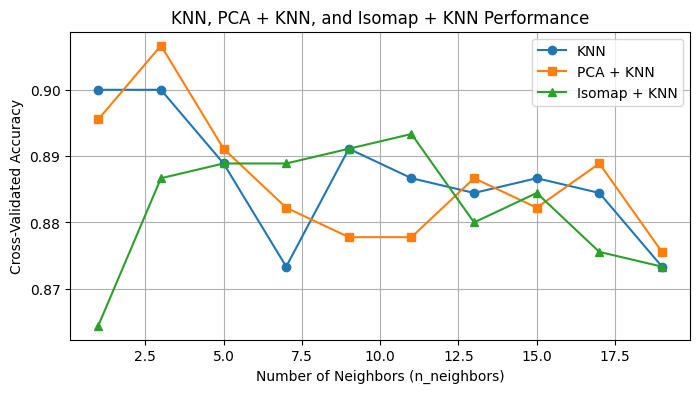

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(n_neighbors_range, knn_scores, label='KNN', marker='o')
plt.plot(n_neighbors_range, pca_knn_scores, label='PCA + KNN', marker='s')
plt.plot(n_neighbors_range, isomap_knn_scores, label='Isomap + KNN', marker='^')

plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN, PCA + KNN, and Isomap + KNN Performance')
plt.legend()
plt.grid(True)
plt.show()

Wow! For 2 dimensions, simple KNN is still better because too much information is lost, but for 6 dimensions they show similar performance. This would significantly reduce memory requirements.